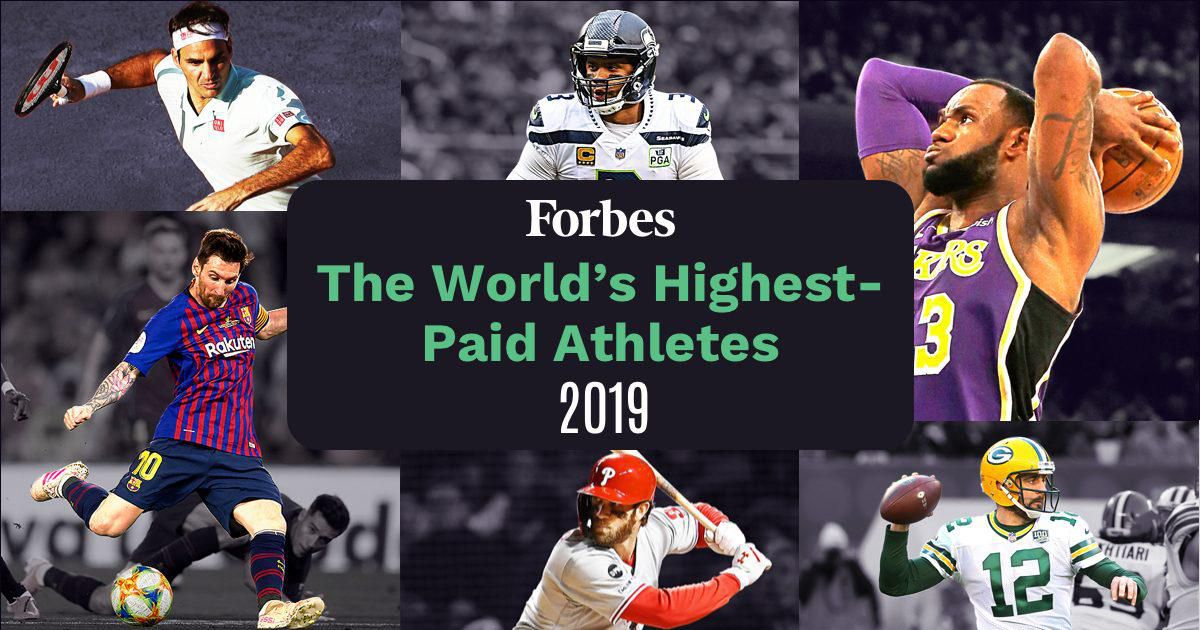

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
plt.style.use("seaborn-pastel")

df = pd.read_excel("Forbes Athlete List 2012-2019.xlsx")
df.head()

,Rank,Name,Pay,Salary/Winnings,Endorsements,Sport,Year
0,#1,Lionel Messi,$127 M,$92 M,$35 M,Soccer,2019
1,#2,Cristiano Ronaldo,$109 M,$65 M,$44 M,Soccer,2019
2,#3,Neymar,$105 M,$75 M,$30 M,Soccer,2019
3,#4,Canelo Alvarez,$94 M,$92 M,$2 M,Boxing,2019
4,#5,Roger Federer,$93.4 M,$7.4 M,$86 M,Tennis,2019


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 795 entries, 0 to 794
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Rank             795 non-null    object
 1   Name             795 non-null    object
 2   Pay              795 non-null    object
 3   Salary/Winnings  795 non-null    object
 4   Endorsements     795 non-null    object
 5   Sport            795 non-null    object
 6   Year             795 non-null    int64 
dtypes: int64(1), object(6)
memory usage: 43.6+ KB


The dataset I am using is from Forbes. Some columns are not consistent across the dataset because Forbes changed their mind about whether to put “#” before the rank value over time. I will fix this one and remove the “dollar signs” and “M”. Also change “Football” to “Football” and “Football” to “American Football”:

In [3]:
df.Rank = df.Rank.apply(lambda x: int(x.split("#")[1]) if type(x) == np.str else x)
df.Pay = df.Pay.apply(lambda x: float(x.split(" ")[0].split("$")[1]))
df.Endorsements = df.Endorsements.apply(lambda x: float(x.split(" ")[0].split("$")[1]))
df["Salary/Winnings"].replace("-",'$nan M',inplace=True)
df["Salary/Winnings"] = df["Salary/Winnings"].apply(lambda x: float(x.split(" ")[0].split("$")[1]))
df.Sport.replace({"Soccer":"Football",
                  "Football":"American Football",
                 "Mixed Martial Arts":"MMA",
                 "Auto racing":"Racing",
                  "Auto Racing":"Racing",
                  "Basketbal":"Basketball",
                 },inplace=True)

df.columns = ['Rank', 'Name', 'Pay', 'Salary_Winnings', 'Endorsements', 'Sport', 'Year']

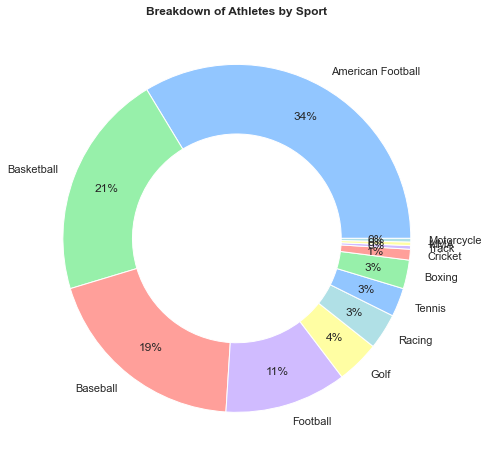

In [4]:
df.groupby("Name").first()["Sport"].value_counts().plot(kind="pie",autopct="%.0f%%",figsize=(8,8),wedgeprops=dict(width=0.4),pctdistance=0.8)
plt.ylabel(None)
plt.title("Breakdown of Athletes by Sport",fontweight="bold")
plt.show()

# Racing Bar Animation for Highest-Paid Athletes Analysis with Python

In [5]:
# Convert the year column to a DateTime object
df.Year = pd.to_datetime(df.Year,format="%Y")

racing_bar_data = df.pivot_table(values="Pay",index="Year",columns="Name")

racing_bar_data.columns[racing_bar_data.isnull().sum() == 0]

Index(['Carmelo Anthony', 'Cristiano Ronaldo', 'Dwight Howard',
       'Justin Verlander', 'LeBron James', 'Lionel Messi', 'Phil Mickelson',
       'Rafael Nadal', 'Roger Federer', 'Tiger Woods'],
      dtype='object', name='Name')

In [6]:
# Convert the data to a cumulative payroll sum over several years

racing_bar_filled = racing_bar_data.interpolate(method="linear").fillna(method="bfill")
racing_bar_filled = racing_bar_filled.cumsum()

In [7]:
# Oversample the dataset with interpolation(linear) for a smooth transition in the frames of the animation

racing_bar_filled = racing_bar_filled.resample("1D").interpolate(method="linear")[::7]

In [8]:
!pip install ffmpeg
!pip install networkx

In [9]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

selected  = racing_bar_filled.iloc[-1,:].sort_values(ascending=False)[:20].index
data = racing_bar_filled[selected].round()

fig,ax = plt.subplots(figsize=(9.3,7))
fig.subplots_adjust(left=0.18)
no_of_frames = data.shape[0] #Number of frames

#initiate the barplot with the first rows of the dataframe
bars = sns.barplot(y=data.columns,x=data.iloc[0,:],orient="h",ax=ax)
ax.set_xlim(0,1500)
txts = [ax.text(0,i,0,va="center") for i in range(data.shape[1])]
title_txt = ax.text(650,-1,"Date: ",fontsize=12)
ax.set_xlabel("Pay (Millions USD)")
ax.set_ylabel(None)

def animate(i):
#     print(f"i={i}/{no_of_frames}")
    #get i'th row of data 
    y = data.iloc[i,:]
    
    #update title of the barplot axis
    title_txt.set_text(f"Date: {str(data.index[i].date())}")
    
    #update elements in both plots
    for j, b, in enumerate(bars.patches):
        #update each bar's height
        b.set_width(y[j])
        
        #update text for each bar (optional)
        txts[j].set_text(f"${y[j].astype(int)}M")
        txts[j].set_x(y[j])

anim=FuncAnimation(fig,animate,repeat=False,frames=no_of_frames,interval=1,blit=False)
anim.save('athletes.gif', writer='imagemagick', fps=120)
plt.close(fig)

MovieWriter imagemagick unavailable; using Pillow instead.


# A GIF Image has been created in the same folder of this project.